In [1]:
# Ressources: https://github.com/slundberg/shap

# Census income classification with LightGBM
This notebook demonstrates how to use LightGBM to predict the probability of an individual making over $50K a year in annual income. It uses the standard UCI Adult income dataset. To download a copy of this notebook visit github.

Gradient boosting machine methods such as LightGBM are state-of-the-art for these types of prediction problems with tabular style input data of many modalities. Tree SHAP (arXiv paper) allows for the exact computation of SHAP values for tree ensemble methods, and has been integrated directly into the C++ LightGBM code base. This allows fast exact computation of SHAP values without sampling and without providing a background dataset (since the background is inferred from the coverage of the trees).

Here we demonstrate how to use SHAP values to understand LightGBM model predictions.

In [2]:
! pip install -U lightgbm
! pip install -U shap

Keyring is skipped due to an exception: 'keyring.backends'
Keyring is skipped due to an exception: 'keyring.backends'


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import shap

# print the JS visualization code to the notebook
shap.initjs()

## Load dataset

In [4]:
X, y = shap.datasets.adult()
X_display, y_display = shap.datasets.adult(display=True)
X_display.head()

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,State-gov,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States
1,50.0,Self-emp-not-inc,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States
2,38.0,Private,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States
3,53.0,Private,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States
4,28.0,Private,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba


In [5]:
y_display

array([False, False, False, ..., False, False,  True])

In [6]:
X.head()

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,7,13.0,4,1,0,4,1,2174.0,0.0,40.0,39
1,50.0,6,13.0,2,4,4,4,1,0.0,0.0,13.0,39
2,38.0,4,9.0,0,6,0,4,1,0.0,0.0,40.0,39
3,53.0,4,7.0,2,6,4,2,1,0.0,0.0,40.0,39
4,28.0,4,13.0,2,10,5,2,0,0.0,0.0,40.0,5


In [7]:
y

array([False, False, False, ..., False, False,  True])

## Train Test Split

In [8]:
# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

In [9]:
# Build training and testing dataset for LGB
d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test)

## Train Model

In [10]:
params = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 10,
    "verbose": -1,
    "min_data": 100,
    "boost_from_average": True
}

model = lgb.train(params=params, 
                  train_set=d_train,
                  num_boost_round=1000, 
                  valid_sets=[d_test], 
                  early_stopping_rounds=50, 
                  verbose_eval=1000)

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[644]	valid_0's binary_logloss: 0.278029


## Model Sanity Check

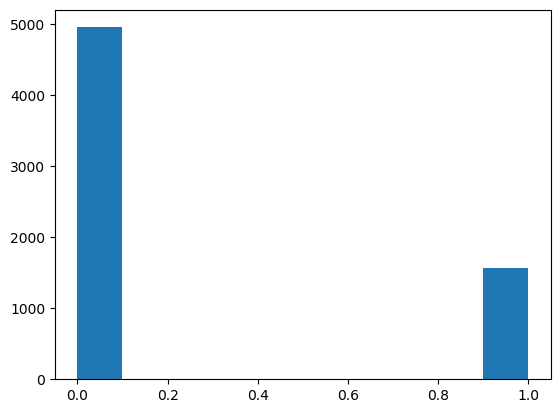

In [11]:
plt.hist(np.where(y_test == False, 0, 1))
plt.show()

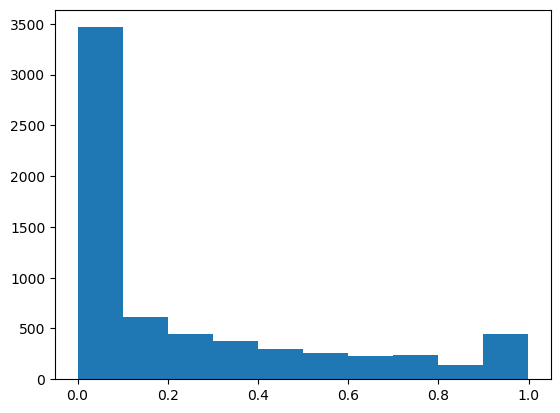

In [12]:
predictions = model.predict(X_test)
plt.hist(predictions)
plt.show()

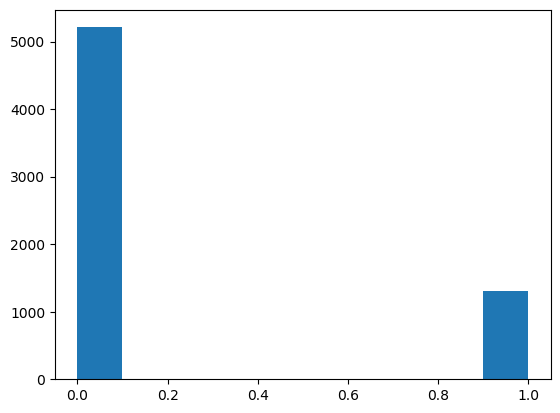

In [13]:
labels = np.where(predictions<0.5, 0, 1)
plt.hist(labels)
plt.show()

## High Level Global Model Explanation via Feature Importance

In [14]:
feature_importance_df = pd.DataFrame(
    data=model.feature_importance(),
    index=X.columns.to_list(),
    columns=['Feature Importance']) \
    .sort_values(by='Feature Importance')

In [15]:
feature_importance_df.head()

,Feature Importance
Sex,104
Race,141
Marital Status,236
Country,239
Workclass,355


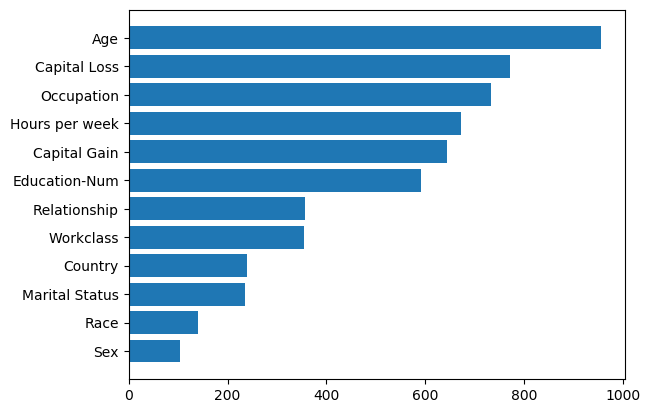

In [16]:
plt.barh(y=feature_importance_df.index.to_list(), 
         width=feature_importance_df['Feature Importance'])
plt.show()

## Global Model Explanation via Shapley Values derived from Game Theory

In [17]:
%%time

# use the fast tree explainer for tree models
explainer = shap.TreeExplainer(model=model, 
                               data=X_train[0:100], # background dataset
                               feature_perturbation="interventional",
                               model_output="probability")
shap_values = explainer.shap_values(X_test)

 99%|===================| 6435/6513 [01:08<00:00]        

CPU times: user 1min 7s, sys: 95.9 ms, total: 1min 8s
Wall time: 1min 8s


In [18]:
shap_values.shape

(6513, 12)

### SHAP Summary Plots

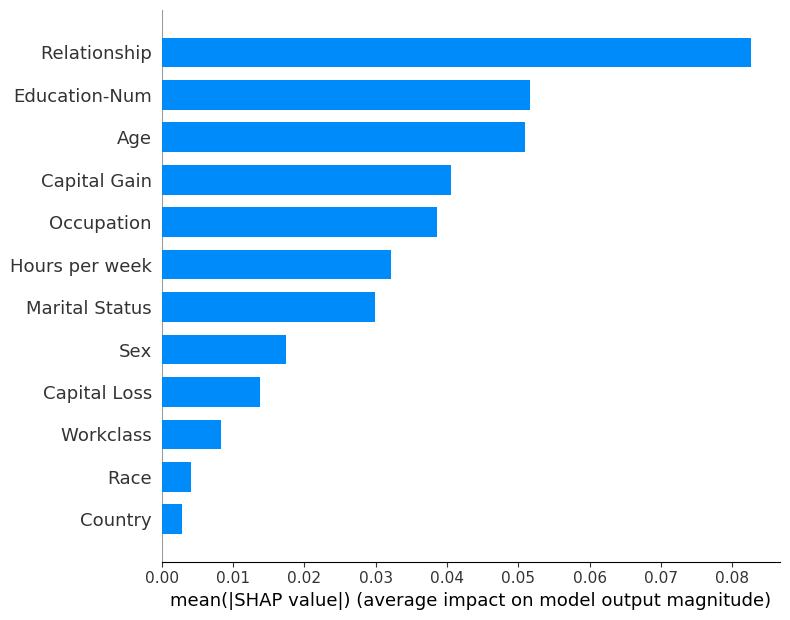

In [19]:
# summary plot: bar plot 
shap.summary_plot(shap_values=shap_values,
                 features=X_test,
                 plot_type="bar")

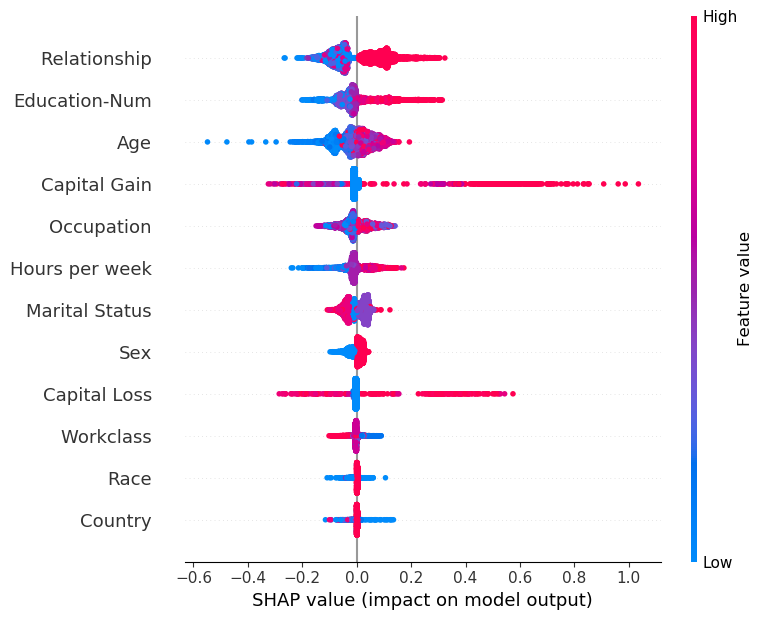

In [20]:
# summary plot: dot plot 
shap.summary_plot(shap_values=shap_values,
                 features=X_test,
                 plot_type="dot")

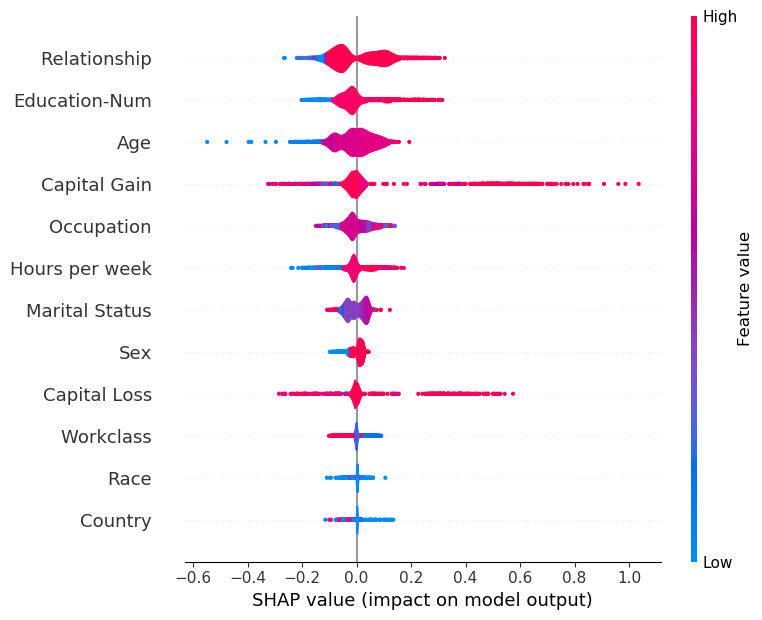

In [21]:
# summary plot: violin plot 
shap.summary_plot(shap_values=shap_values,
                 features=X_test,
                 plot_type="violin")

### SHAP Dependence Plots

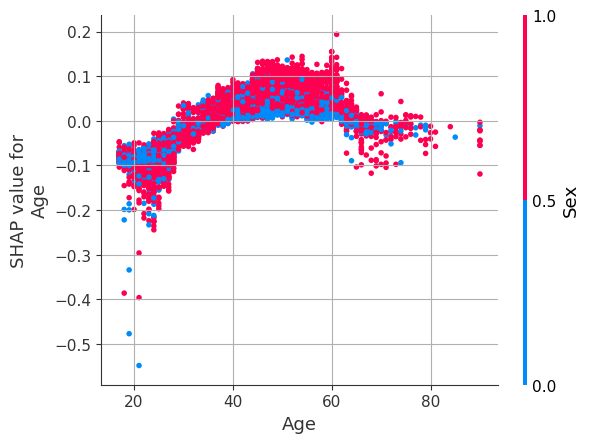

In [22]:
fig, ax = plt.subplots()
shap.dependence_plot(
    ind='Age',
    shap_values=shap_values,
    features=X_test,
    interaction_index='Sex',
    ax=ax,
    show=False
)
plt.grid()
plt.show()

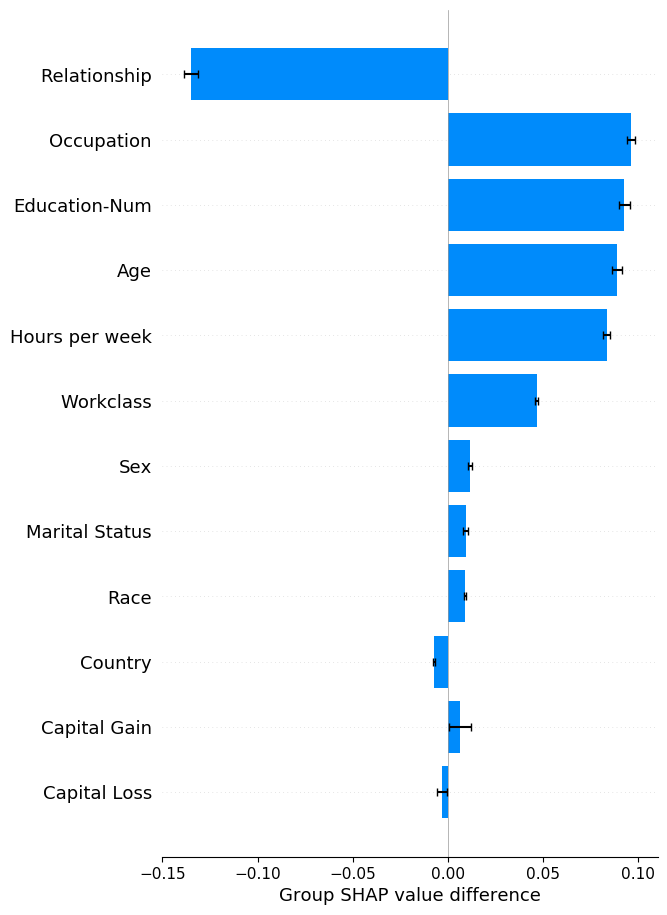

In [23]:
# This plots the difference in mean SHAP values between two groups.
shap.group_difference_plot(
    shap_values=shap_values,
    group_mask=X_test['Sex'].values,
    feature_names=X_test.columns.to_list())

## Local Model Explanations - Visualze Single Model Predictions

In [24]:
observation = 1
y_test[observation]

True

In [25]:
model.predict(X_test.iloc[observation,:])

Converting data to scipy sparse matrix.


array([0.67383917])

In [26]:
# explain single prediction
shap.force_plot(base_value=explainer.expected_value, 
                shap_values=shap_values[observation,:], 
                features=X_display.iloc[observation,:])

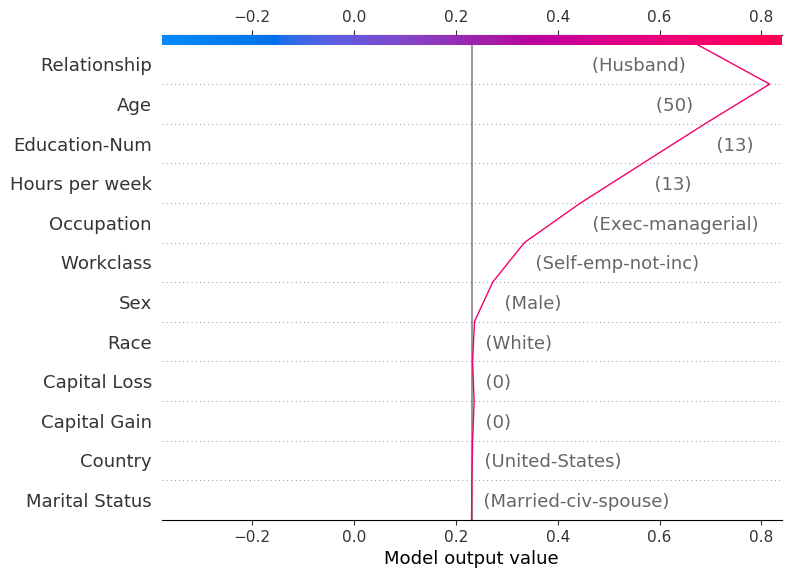

In [27]:
# explain single prediction
shap.decision_plot(base_value=explainer.expected_value, 
                    shap_values=shap_values[observation,:], 
                    features=X_display.iloc[observation,:])

### From Single Observations to Many

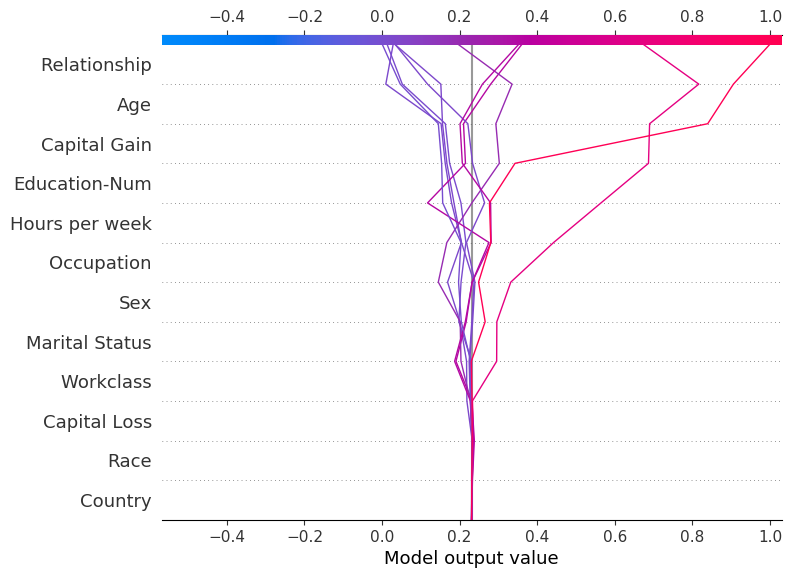

In [28]:
# explain single prediction
observations = 10
shap.decision_plot(base_value=explainer.expected_value, 
                shap_values=shap_values[:observations,:], 
                features=X_display.iloc[:observations,:])

In [29]:
nobservations = 100
shap.force_plot(base_value=explainer.expected_value, 
                shap_values=shap_values[:nobservations,:], 
                features=X_display.iloc[:nobservations,:])

### Other SHAP Exlplainers

In [30]:
%%time
explainer = shap.Explainer(model=model, 
                           masker=X_train[0:100], # background dataset
                           algorithm="tree",
                           model_output="probability")
shap_values = explainer.shap_values(X_test)

 99%|===================| 6417/6513 [01:08<00:01]        

CPU times: user 1min 8s, sys: 154 ms, total: 1min 8s
Wall time: 1min 8s


In [31]:
# explain single prediction
observation = 1
shap.force_plot(base_value=explainer.expected_value, 
                shap_values=shap_values[observation,:], 
                features=X_display.iloc[observation,:])

In [32]:
%%time
# use an alternative model agnostic explainer; 
explainer = shap.SamplingExplainer(model=model.predict, 
                                   data=X_train, # background dataset
                                  )
shap_values = explainer.shap_values(X_test[:10])

Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.



CPU times: user 1min 47s, sys: 454 ms, total: 1min 47s
Wall time: 1min 40s


In [33]:
# explain single prediction
shap.force_plot(base_value=explainer.expected_value, 
                shap_values=shap_values[observation,:], 
                features=X_display.iloc[observation,:])

In [34]:
%%time
# use an alternative model agnostic explainer; the kernel explainer is also used by sagemaker --> slow but model agnostic!
explainer = shap.KernelExplainer(model=model.predict, 
                                 data=X_train[:100], # background dataset
                                  )
shap_values = explainer.shap_values(X_test[:10])


CPU times: user 1min 18s, sys: 835 ms, total: 1min 19s
Wall time: 46 s


In [35]:
# explain single prediction
shap.force_plot(base_value=explainer.expected_value, 
                shap_values=shap_values[observation,:], 
                features=X_display.iloc[observation,:])